In [54]:
import numpy as np
import pandas as pd
import sklearn.utils as utils
import sklearn.linear_model as models
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_validate
from similartiy_fun import numerical_similarity_fun, categorical_similarity_fun, voting_similarity
import matplotlib.pyplot as plt 
from sklearn.ensemble import AdaBoostClassifier

In [55]:
def get_data(path, sep = ',', names = None):
    df = pd.read_table(path , header=None, sep=sep, names = names)
    data = df.values
    return data

In [56]:
def processed_data(data,  numerical_columns):
    processed_data = []
    
    processed_data_n = data[:,numerical_columns]
    processed_data_n = normalize(processed_data_n,axis=1)
    processed_data_n = np.concatenate((processed_data_n, data[:,-1].reshape(-1,1)), axis = 1)
    
    categorical_cols = np.setdiff1d(range(len(data[1])-1),numerical_columns)
    processed_data_c = data[:,categorical_cols]
    processed_data_c = np.concatenate((processed_data_c, data[:,-1].reshape(-1,1)), axis = 1)
                    
    return processed_data_n, processed_data_c

In [57]:
def get_similarity_Matrix(data, similarity_function):
    sm = []
    lables = []
    for i in range(len(data)):
        for j in range(i,len(data)): # only get the upper right of the similarity matrix

            sm.append(similarity_function(data[i][:-1],data[j][:-1])) #exculde the label
            lables.append(data[i][-1] == data[j][-1])
           
    return np.array(sm).reshape(-1,1),np.array(lables).reshape(-1,1)

In [58]:
def down_sample_data(classifer_data):
    classifier_data = classifer_data[classifer_data[:,1].argsort()] #sort by lables
    lable0_count = (classifier_data[:,1] == 0).sum()
    lable1_count = len(classifier_data)- lable0_count
    slice_size = min(lable0_count, lable1_count)    
    # shuffle each lable part individually
    classifier_data[:lable0_count] = utils.shuffle(classifier_data[:lable0_count]) 
    classifier_data[lable0_count:] = utils.shuffle(classifier_data[lable0_count:])
   # sample from each lable by the slice size
    classifier_data0 = classifier_data[:slice_size]
    classifier_data1 = classifier_data[-slice_size:]
    # concatente the samples
    classifier_data = np.concatenate((classifier_data0, classifier_data1), axis= 0)
    classifier_data = utils.shuffle(classifier_data)
    return classifier_data

In [59]:
def get_similarity_metrics(path_to_data, data_sep, numerical_columns, similarity_fn = None, similarity_type=1): 
    #similarity types 1 - numerical 2 - categorical 3 - mixed
    # numerical columns = indecies of numerical cols
    f_scores = []
    data = get_data(path_to_data, data_sep)
    processed_data_n, processed_data_c = processed_data(data, numerical_columns) #split the features into numerical and categorical

    
    if (similarity_type == 1): 
        data = processed_data_n
    elif (similarity_type == 2):
        data = processed_data_c

    if (similarity_type == 3):
        voting_similarity_n = lambda o1,o2 :voting_similarity(o1,o2,True)
        measures_n, lables_n = get_similarity_Matrix(processed_data_n,voting_similarity_n)
        measures_c, lables_c = get_similarity_Matrix(processed_data_c,voting_similarity)        
        measures = np.average((measures_n, measures_c), axis=0)   # take the avg of the two measures
        lables = lables_c
    else:
        measures , lables = get_similarity_Matrix(data, similarity_fn)
        
        
    classifier_data = down_sample_data(np.concatenate((measures,lables),axis=1)) # get balanced data by downsampling
    classifer_input = classifier_data[:,0].reshape(-1,1)
    classifer_targets = classifier_data[:,1]
    
    
    clf = AdaBoostClassifier()
    
    scoring = ['f1_macro', 'precision_macro', 'recall_macro']

    #train the classifier and get scores   
    scores = cross_validate(clf, classifer_input, classifer_targets, cv=5, scoring=scoring, return_train_score=False)
    for score in scores:
        if(score == 'fit_time' or score == 'score_time'):
            continue
        f_scores.append(np.average(scores[score]))
        print(score, ': ', np.average(scores[score]))
    return np.array(f_scores).T

In [60]:
# get data links, sep and neumaric cols indices
maram_data = ('https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data', ',', [0,3]) 
safana_data = ('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', ',', [0,1]) 
nosiba_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data', ',', [1,3,5,7,9]
ola_data = ('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', ' ', [1, 4, 7, 10, 12, 15, 17])

############### Numerical Similarity ###############
------------ cosine ----------------------
test_f1_macro :  0.35767075971610457
test_precision_macro :  0.6249934845134096
test_recall_macro :  0.5079883090920089
------------ Euclidean_distance ----------------------
test_f1_macro :  0.5161129303236074
test_precision_macro :  0.5216398863206889
test_recall_macro :  0.5207755763591883
------------ wieghted_euclidean ----------------------
test_f1_macro :  0.5193048046659514
test_precision_macro :  0.5204584235036354
test_recall_macro :  0.5202919190680569
------------ mahalanobis ----------------------
test_f1_macro :  0.5156888957079853
test_precision_macro :  0.5221629846389819
test_recall_macro :  0.5211565353076126
------------ minkowski ----------------------
test_f1_macro :  0.5212536397535703
test_precision_macro :  0.5213562531672855
test_recall_macro :  0.5213411653761987


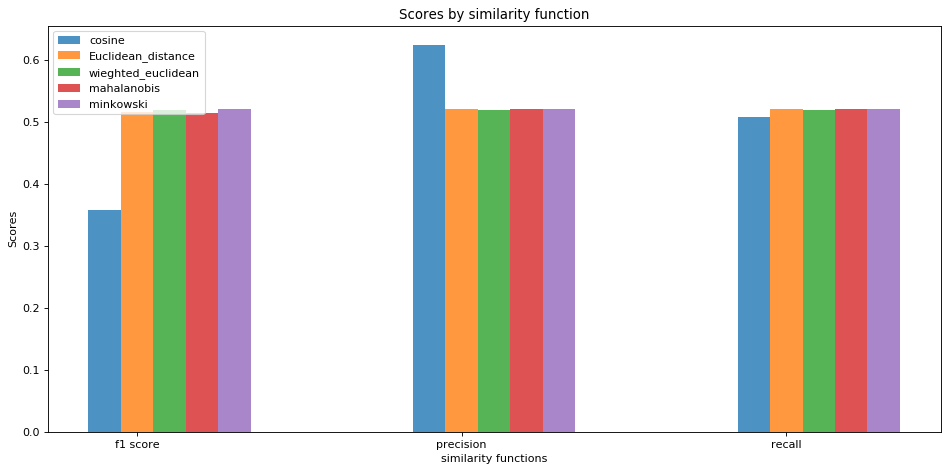

In [61]:
# similarity functions scores on numerical features
scores_n = []
print('############### Numerical Similarity ###############')
for similarity_fun in numerical_similarity_fun:
    print('------------',similarity_fun,'----------------------')
    f_score = get_similarity_metrics(*maram_data, numerical_similarity_fun[similarity_fun], similarity_type=1)
    scores_n.append(f_score)
scores_n = np.array(scores_n)

#plot numerical scores per simialarity function 
no_metrics = 3
index = np.arange(no_metrics)

bar_width = 0.1
opacity = 0.8
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

metrics = ['f1 score', 'precision', 'recall']
funs_n = list(numerical_similarity_fun.keys())

for i in range(len(scores_n)): #plot scores per each function
    metric_results = scores_n[i] 
    plt.bar(index + bar_width * i, metric_results, bar_width,alpha=opacity,label=funs_n[i])

plt.xlabel('similarity functions')
plt.ylabel('Scores')
plt.title('Scores by similarity function')
plt.xticks(index + bar_width, metrics)
plt.legend()
plt.tight_layout()
axes = plt.gca()
# axes.set_ylim([0.5,0.525])


############### Categorical Similarity ###############
------------ cosine ----------------------
test_f1_macro :  0.5079135640012067
test_precision_macro :  0.5134345676424124
test_recall_macro :  0.5128808890307985
------------ overlap ----------------------
test_f1_macro :  0.4829221508487655
test_precision_macro :  0.5087455911866972
test_recall_macro :  0.5069611694321784
------------ Jaccard_Distance ----------------------
test_f1_macro :  0.5027449598678396
test_precision_macro :  0.5116696115955361
test_recall_macro :  0.5109033189994447
------------ Monge_Elkan ----------------------
test_f1_macro :  0.5098895528336038
test_precision_macro :  0.5125962821140775
test_recall_macro :  0.5123439086463222
------------ dice ----------------------
test_f1_macro :  0.502523994200529
test_precision_macro :  0.5113826313878067
test_recall_macro :  0.5106419808427815
------------ soft_TF_IDF ----------------------
test_f1_macro :  0.513375160778706
test_precision_macro :  0.5148907851422

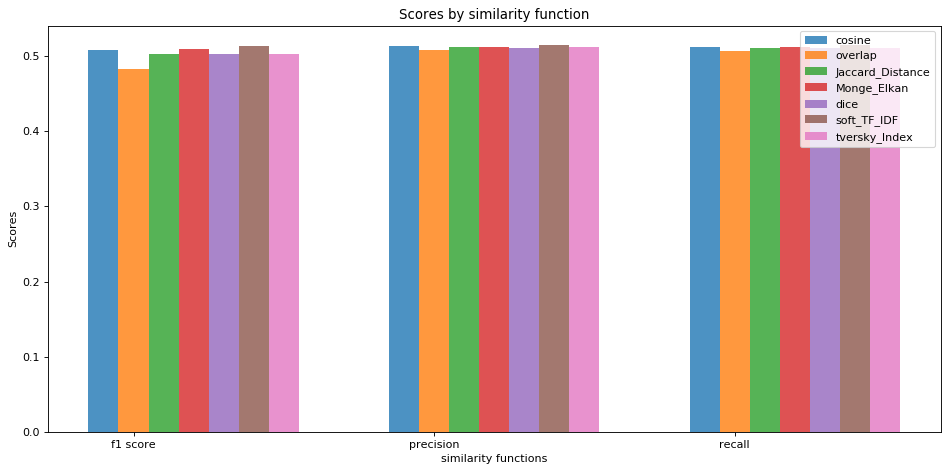

In [63]:
# similarity functions scores on categorical features
scores_c = []
print('############### Categorical Similarity ###############')
for similarity_fun in categorical_similarity_fun:
    print('------------',similarity_fun,'----------------------')
    f_score = get_similarity_metrics(*maram_data, categorical_similarity_fun[similarity_fun], similarity_type=2)
    scores_c.append(f_score)
scores_c = np.array(scores_c)

#plot categorical scores per simialarity function 
no_metrics = 3
index = np.arange(no_metrics)

bar_width = 0.1
opacity = 0.8
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

metrics = ['f1 score', 'precision', 'recall']
funs_n = list(categorical_similarity_fun.keys())

for i in range(len(scores_c)): #plot scores per each function
    metric_results = scores_c[i] 
    plt.bar(index + bar_width * i, metric_results, bar_width,alpha=opacity,label=funs_n[i])

plt.xlabel('similarity functions')
plt.ylabel('Scores')
plt.title('Scores by similarity function')
plt.xticks(index + bar_width, metrics)
plt.legend()
plt.tight_layout()

############### Mix Similarity ###############
------------ Mixed fun ----------------------


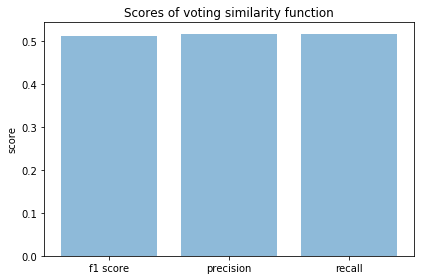

In [53]:
# similarity function score on mixed features
print('############### Mix Similarity ###############')
print('------------','Mixed fun','----------------------')
# scores = get_similarity_metrics(*maram_data, similarity_type=3)

metrics = ['f1 score', 'precision', 'recall']
y_pos = np.arange(len(metrics))
 
#plot mixed scores for voting similarity function

plt.bar(y_pos, scores , align='center', alpha=0.5)
plt.xticks(y_pos, metrics)
plt.ylabel('score')
plt.title('Scores of voting similarity function')
plt.tight_layout()
# plt.show()